In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import csv
import pandas as pd

In [4]:
#df = pd.read_csv("/content/drive/Shareddrives/CS238 Project/Cushing_OK_WTI_Spot_Price_FOB.csv")

df = pd.read_csv("data/oil_data/NYMEX_futures/Cushing_OK_Crude_Oil_Future_Contract_1.csv")

In [ ]:
df.head()

,10/27/2025,62.13
0,10/24/2025,62.27
1,10/23/2025,62.44
2,10/22/2025,59.30
3,10/21/2025,58.66
4,10/20/2025,58.34


In [ ]:
df = pd.read_csv(
    '/content/drive/Shareddrives/CS238 Project/Cushing_OK_WTI_Spot_Price_FOB.csv',
    header=None,
    names=['Date', 'Price']
)

# Convert to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Sort by date (ascending = oldest to newest)
df_sorted = df.sort_values('Date')

# Or for newest → oldest:
# df_sorted = df.sort_values('Date', ascending=False)

# Save back to CSV
df_sorted.to_csv('/content/drive/Shareddrives/CS238 Project/Cushing_OK_WTI_Spot_Price_FOB_sorted.csv', index=False)

            Date  Price
10024 1986-01-02  25.56
10023 1986-01-03  26.00
10022 1986-01-06  26.53
10021 1986-01-07  25.85
10020 1986-01-08  25.87


In [ ]:
def sort_csv(path):
  df = pd.read_csv(path, 
    header=None,
    names=['Date', 'Price']
  )

  # Convert to datetime
  df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

  # Sort by date (ascending = oldest to newest)
  df_sorted = df.sort_values('Date')

  # Or for newest to  oldest:
  # df_sorted = df.sort_values('Date', ascending=False)

  # Save back to CSV
  df_sorted.to_csv(path, index=False)

In [ ]:
df_sorted

,Date,Price
10024,1986-01-02,25.56
10023,1986-01-03,26.00
10022,1986-01-06,26.53
10021,1986-01-07,25.85
10020,1986-01-08,25.87
...,...,...
4,2025-10-21,58.66
3,2025-10-22,59.30
2,2025-10-23,62.44
1,2025-10-24,62.27


In [ ]:
%pip install openmeteo-requests
%pip install requests_cache
%pip install retry-requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 725.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 1.5 MB/s eta 0:00:00


In [ ]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "1986-01-01",
	"end_date": "2025-11-01",
	"daily": "temperature_2m_mean",
	"bounding_box": "-25,-110,55,-78",
	}
responses = openmeteo.weather_api(url, params=params)

# Process bounding box locations
for response in responses:
	print(f"\nCoordinates: {response.Latitude()}°N {response.Longitude()}°E")
	print(f"Elevation: {response.Elevation()} m asl")
	print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

	# Process daily data. The order of variables needs to be the same as requested.
	daily = response.Daily()
	daily_temperature_2m_mean = daily.Variables(0).ValuesAsNumpy()

	daily_data = {"date": pd.date_range(
		start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
		end =  pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = daily.Interval()),
		inclusive = "left"
	)}

	daily_data["temperature_2m_mean"] = daily_temperature_2m_mean

	daily_dataframe = pd.DataFrame(data = daily_data)
	print("\nDaily data\n", daily_dataframe)


OpenMeteoRequestsError: failed to request 'https://archive-api.open-meteo.com/v1/archive': {'error': True, 'reason': 'Bounding box calls not supported for domain archive_best_match'}

In [1]:
! pip install earthengine-api
! earthengine authenticate

E0000 00:00:1762986953.745987     474 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762986953.752749     474 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762986953.770093     474 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762986953.770141     474 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762986953.770146     474 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762986953.770150     474 computation_placer.cc:177] computation placer already registered. Please check linka

In [2]:
# DO NOT SELECT 'Use read-only scopes'

import ee
ee.Authenticate()
ee.Initialize()

# Importance of Cushing, OK

WTI assessed prices are used as oil benchmark prices

"The NYMEX Crude Oil contract trades under the symbol CL on the New York Mercantile Exchange, now part of Chicago Mercantile Exchange.[2] The contract is for 1,000 US barrels, or 42,000 US gallons, of WTI crude oil, the minimum tick size of the contract is \$0.01 per barrel (\|$10 for contract), and the contract price is quoted in US dollars." [Wiki]

https://www.cmegroup.com/education/articles-and-reports/why-cushing-matters-a-look-at-the-wti-benchmark.html

# Inbound pipelines to Cushing

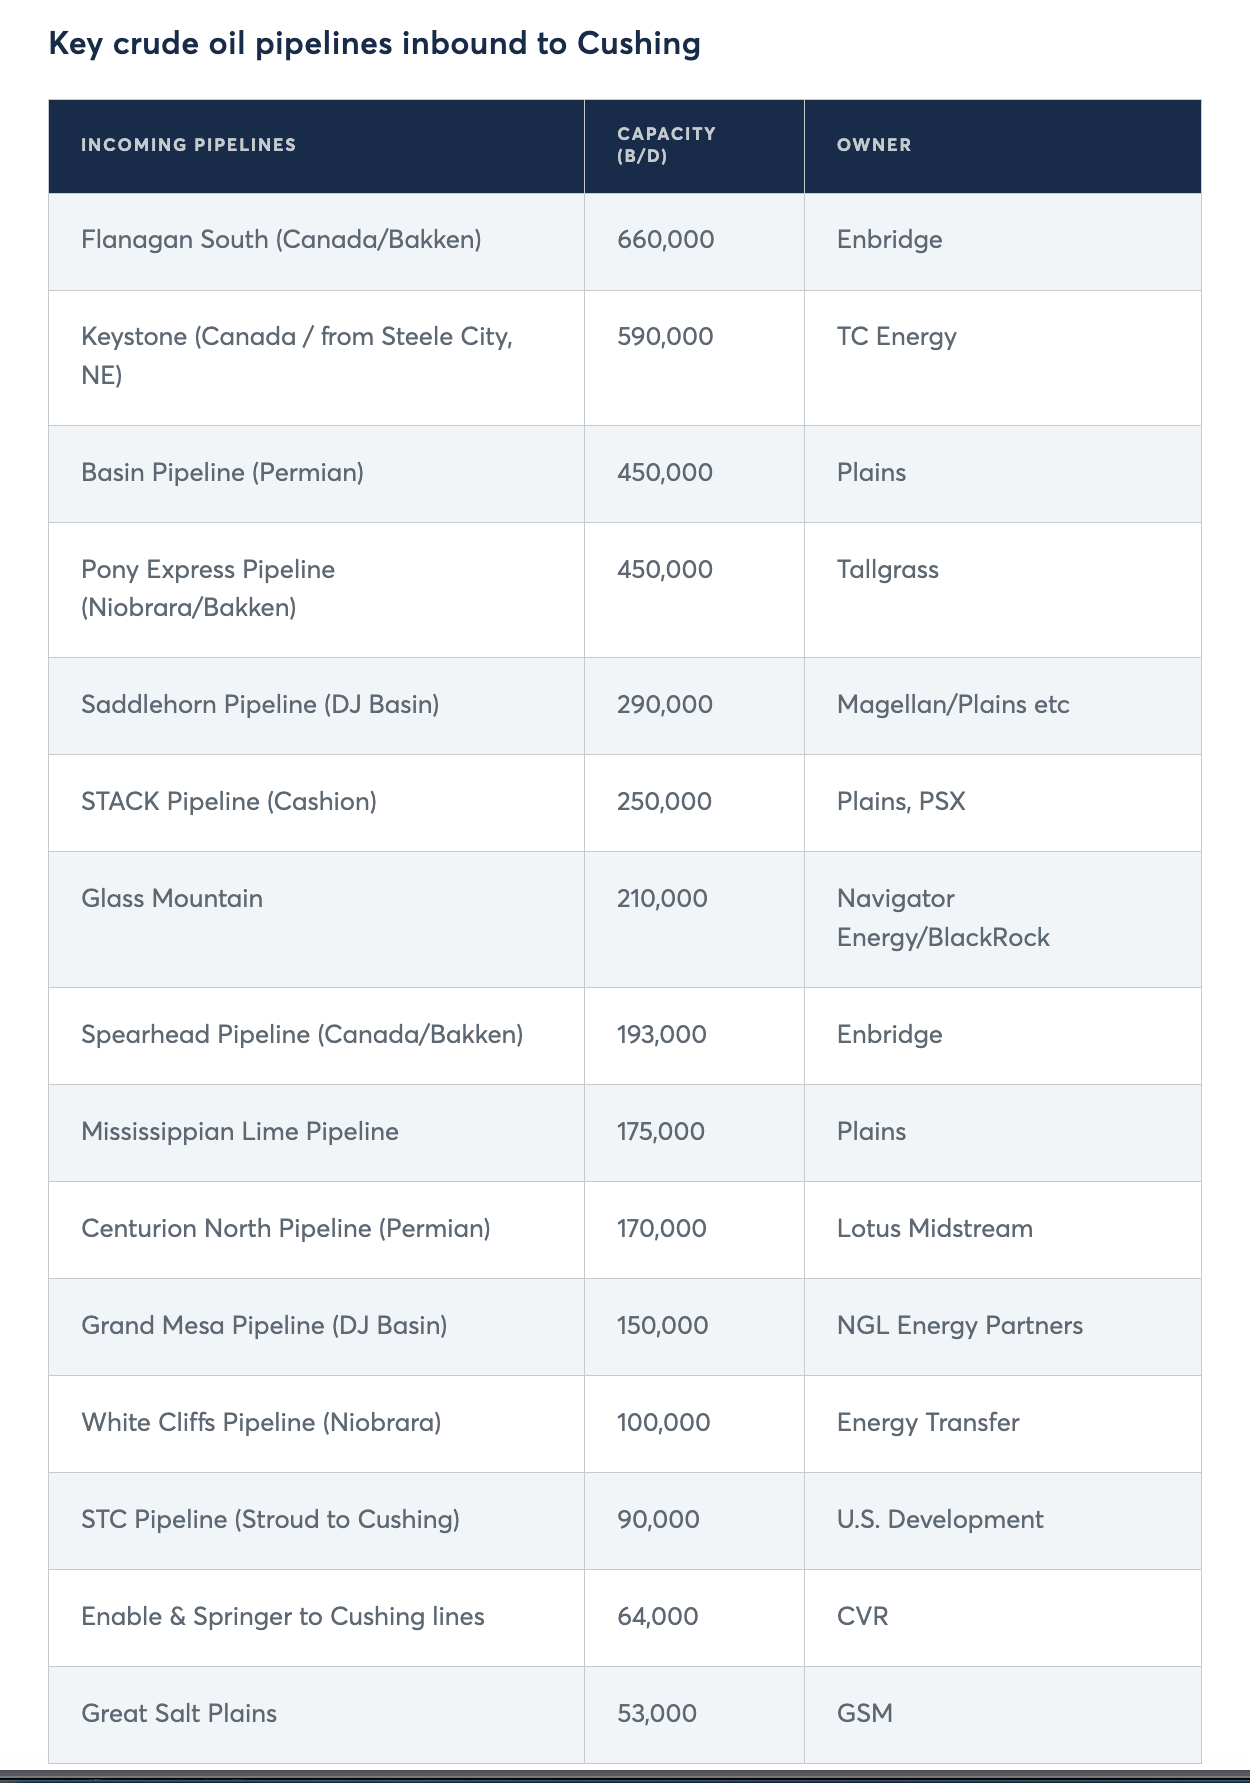

# Outbound pipelines from Cushing

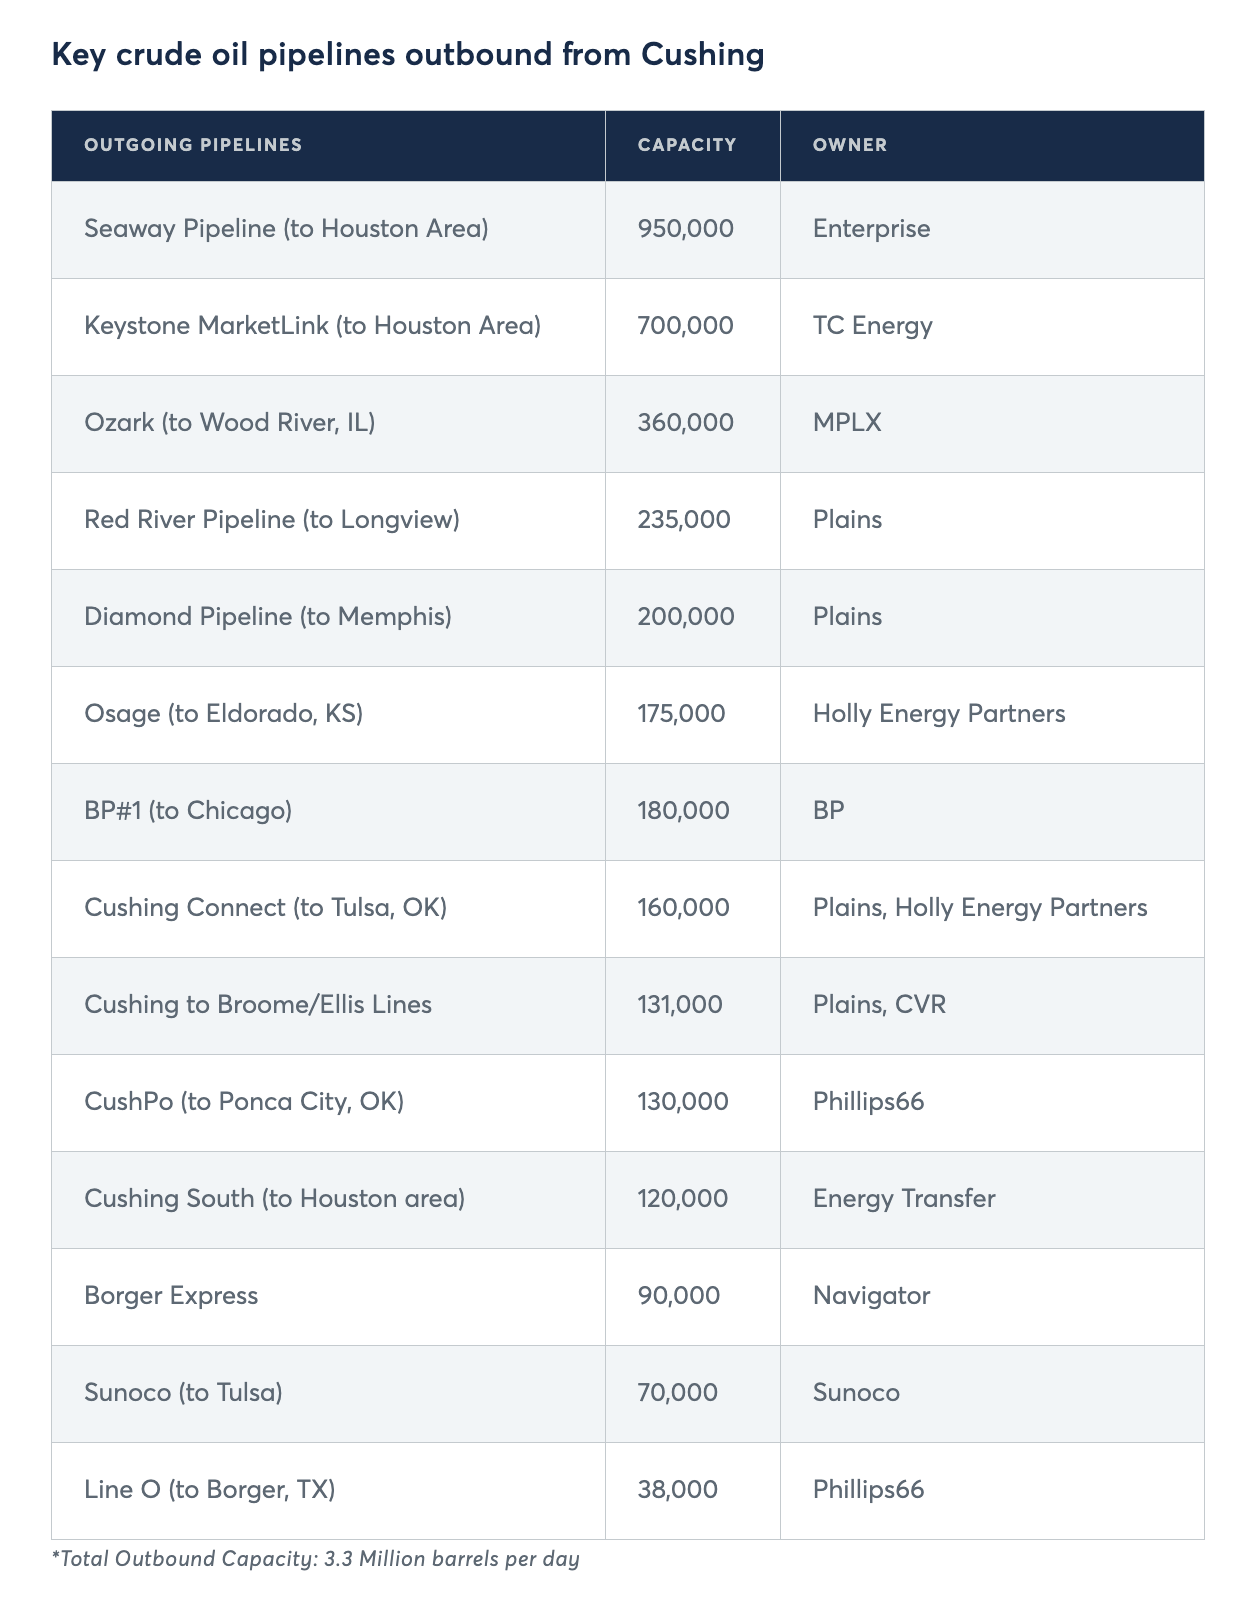

# Where is the oil drilled?

__Domestic sources__
- Permian Basin: Pipelines from fields in west Texas and southeast New Mexico connect to the Cushing hub.
- Mid-Continent: Oil from fields in western and north-central Oklahoma, southern Kansas, and around Medford, Oklahoma, flows into Cushing.
- Other U.S. regions: Oil is also sourced from areas like the Bakken and Niobrara shale plays, with some coming from fields in Wyoming, Colorado, and Illinois, though it may bypass Cushing and go directly to refineries.

From Chat
- The Permian Basin (West Texas & Southeastern New Mexico)
- The Eagle Ford Shale (South Texas)
- The SCOOP/STACK and Anadarko Basin (Central Oklahoma)
- The Bakken Formation (North Dakota / Montana)

__International sources__
- Canada: The Keystone Pipeline brings oil from Alberta, Canada, to Cushing.

In [ ]:
# Rough bounding boxes
permian = [-106 E, -100.5 E, 29.46 N, 33 N] # as a square
eagle_ford_corners_triangle = [(24.5, -99.5), (28.9, -100.55), (31, -96)]
nc_oklahoma = [34.5, -97.4, 36.8, -96.7]
ne_oklahoma = [35, -96.3, 36.9, -95]
nw_ok = [35.6, -101.8, 36.8, -97.7]

sw_kansas = [37, -102. 38.4, -100]
central_kansas = [37, -99.5, 38.9, -97.4]
se_kansas = [37, -96, 39, -96.7]

bakken = [46, -106, 48.9, -99.5]
saskatchewan = [49, -107, 50, -101]

canada_rough = [(49, -114), (49, -109.8), (58.5, -120.7), (58.4, -116.7)]

n_alaska = [69.3, -157.9, 70.3, -148.8]
s_alaska = [(58.6, -152.4), (60.5, -132.3), (62.2, -149.7)]

texas = ee.Geometry.Rectangle([-106.65, 25.84, -93.51, 36.5])
oklahoma = ee.Geometry.Rectangle([-103.0, 33.6, -94.4, 37.1])

# Optional: pipeline corridor (Permian Basin → Cushing)
pipeline = ee.Geometry.LineString([
    [-102.08, 31.86],  # Midland, TX
    [-97.96, 35.99]    # Cushing, OK
]).buffer(20000)  # 20 km buffer zone


In [ ]:
permian = ee.Geometry.Rectangle([-106, 29.46, -100.5, 33])

nc_oklahoma = ee.Geometry.Rectangle([-97.4, 34.5, -96.7, 36.8])
ne_oklahoma = ee.Geometry.Rectangle([-96.3, 35, -95, 36.9])
nw_ok = ee.Geometry.Rectangle([-101.8, 35.6, -97.7, 36.8])

sw_kansas = ee.Geometry.Rectangle([-102,37, -100, 38.4])
central_kansas = ee.Geometry.Rectangle([-99.5, 37, -97.4, 38.9])
se_kansas = ee.Geometry.Rectangle([-96.7, 37, -96, 39])

bakken = ee.Geometry.Rectangle([-106, 46, -99.5, 48.9])
saskatchewan = ee.Geometry.Rectangle([-107, 49, -101, 50])

n_alaska = ee.Geometry.Rectangle([-157.9, 69.3, -148.8, 70.3])

eagle_ford_corners_triangle = ee.Geometry.Polygon([
    [-99.5, 24.5],
    [-100.55, 28.9],
    [-96, 31]
])

canada_rough = ee.Geometry.Polygon([
    [-114, 49],
    [-109.8, 49],
    [-120.7, 58.5],
    [-116.7, 58.4]
])

s_alaska = ee.Geometry.Polygon([
    [-152.4, 58.6],
    [-132.3, 60.5],
    [-149.7, 62.2]
])

In [3]:
def get_weather_info(region, region_name, granularity):
  # use daily aggregation because this is the only info we need and faster
  dataset = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
      .filterDate('1986-01-01', '2025-11-01') \
      .filterBounds(region) \
      .select('temperature_2m', 'total_precipitation_sum')

  def daily_stats(img):
      mean = img.reduceRegion(
          reducer=ee.Reducer.mean(),
          geometry=region.bounds(),
          scale=granularity,
          maxPixels=1e9
      )
      return ee.Feature(None, {
          'date': img.date().format('YYYY-MM-dd'),
          'mean_temp_K': mean.get('temperature_2m'),
          'total_precip_mm': ee.Number(mean.get('total_precipitation_sum')).multiply(1000)
      })

  fc = dataset.map(daily_stats)

  task = ee.batch.Export.table.toDrive(
      collection=fc,
      description=f'{region_name}_dailyaggr',
      folder='earth_engine',
      fileFormat='CSV'
  )
  task.start()
  print(f"Export started for {region_name}— check https://code.earthengine.google.com -> Tasks tab to monitor progress.")


In [ ]:
get_weather_info(s_alaska, "s_alaska", 25000)

Export started for s_alaska— check https://code.earthengine.google.com -> Tasks tab to monitor progress.


In [4]:
texas_gulf_polygon = [
    [-98.5, 25.0],  # offshore S of Corpus Christi
    [-100.0, 28.8], # inland S of San Antonio / Eagle Ford edge
    [-98.0, 32.0],  # N of Dallas/Fort Worth east side of Permian link
    [-94.0, 31.8],  # N of Houston
    [-88.0, 29.5],  # central LA coast
    [-91.0, 26.0],  # Gulf offshore S of LA
    [-95.5, 25.0],  # offshore S of TX coast
    [-98.5, 25.0],  # close polygon
]

permian_basin_polygon = [
    [-105.22, 34.02],
    [-100.04, 34.02],
    [-100.04, 29.46],
    [-105.22, 29.46],
    [-105.22, 34.02],
]

ok_ntx_polygon = [
    [-101.5, 32.0], # W of Abilene
    [-101.5, 37.5], # TX/OK panhandle area
    [-94.0, 37.5],  # SE Kansas / SW Missouri
    [-94.0, 32.0],  # NE Texas / Shreveport region
    [-101.5, 32.0],
]

midwest_corridor_polygon = [
    [-103.0, 36.5], # western KS / OK panhandle
    [-103.0, 45.5], # eastern WY / western SD/NE
    [-87.0, 45.5],  # WI / upper MI
    [-87.0, 36.5],  # southern IL / KY
    [-103.0, 36.5],
]

rockies_corridor_polygon = [
    [-112.0, 37.0], # Utah/CO border area
    [-112.0, 46.5], # western MT/WY line
    [-101.0, 46.5], # central ND/SD
    [-101.0, 37.0], # western KS/CO
    [-112.0, 37.0],
]

bakken_polygon = [
    [-107.07, 48.996],  # NW
    [-99.61, 48.996],   # NE
    [-99.61, 46.496],   # SE
    [-107.07, 46.496],  # SW
    [-107.07, 48.996],
]

western_canada_polygon = [
    [-120.0, 48.5], # near BC/AB, at US border
    [-120.0, 57.5], # N of Fort McMurray
    [-101.0, 57.5], # northern SK
    [-101.0, 48.5], # US–Canada border SK/MB
    [-120.0, 48.5],
]

alaska_taps_polygon = [
    [-151.0, 71.0],  # NW of Prudhoe
    [-151.0, 60.5],  # W of Valdez
    [-144.0, 60.5],  # SE of Valdez
    [-144.0, 71.0],  # NE of Prudhoe
    [-151.0, 71.0],
]

# Master mapping: name -> polygon
pipeline_regions = {
    "pipeline_texas_gulf_coast": texas_gulf_polygon,
    "pipeline_permian_basin": permian_basin_polygon,
    "pipeline_ok_ntx_hub": ok_ntx_polygon,
    "pipeline_midwest_corridor": midwest_corridor_polygon,
    "pipeline_rockies_corridor": rockies_corridor_polygon,
    "pipeline_bakken_region": bakken_polygon,
    "pipeline_western_canada": western_canada_polygon,
    "pipeline_alaska_taps": alaska_taps_polygon,
}

In [7]:
for (name, data) in pipeline_regions.items():
  get_weather_info(ee.Geometry.Polygon(data), name, 100000)

Export started for pipeline_texas_gulf_coast— check https://code.earthengine.google.com -> Tasks tab to monitor progress.
Export started for pipeline_permian_basin— check https://code.earthengine.google.com -> Tasks tab to monitor progress.
Export started for pipeline_ok_ntx_hub— check https://code.earthengine.google.com -> Tasks tab to monitor progress.
Export started for pipeline_midwest_corridor— check https://code.earthengine.google.com -> Tasks tab to monitor progress.
Export started for pipeline_rockies_corridor— check https://code.earthengine.google.com -> Tasks tab to monitor progress.
Export started for pipeline_bakken_region— check https://code.earthengine.google.com -> Tasks tab to monitor progress.
Export started for pipeline_western_canada— check https://code.earthengine.google.com -> Tasks tab to monitor progress.
Export started for pipeline_alaska_taps— check https://code.earthengine.google.com -> Tasks tab to monitor progress.
